# Documentation #003

In [7]:
# This code block is just some data cleaning, which I did in an unpleasant manner since I just sort of adopted from another round 
# of cleaning I did last year while trying to create some plots. Please ignore this code block.

import pandas as pd
import numpy as np

df = pd.read_csv("http://www.casact.org/research/reserve_data/wkcomp_pos.csv")

def clean_testgraph(company_code):
    cdata = df.loc[df['GRCODE'] == company_code, ['AccidentYear','DevelopmentLag'
                                                  ,'IncurLoss_D','CumPaidLoss_D'
                                                  ,'BulkLoss_D','EarnedPremDIR_D']]
    cdata = cdata.rename(index=str, columns={'AccidentYear':'accident_year'  
                                            ,'DevelopmentLag':'dev'
                                            ,'IncurLoss_D':'incurred_loss'
                                            ,'CumPaidLoss_D':'paid_loss'
                                            ,'BulkLoss_D': 'bulk_loss'
                                            ,'EarnedPremDIR_D':'premium'})
    # origin: specify cohort
    cdata['origin'] = cdata['accident_year']-(cdata['accident_year'].min())+1
    
    cdata0 = cdata.loc[cdata['dev'] == 1]
    cdata0[['dev','incurred_loss','paid_loss','bulk_loss']] = 0
    cdata = pd.concat([cdata0,cdata])
    
    # add calendar period and sort data by origin, and then dev
    cdata['cal'] = cdata['origin']+cdata['dev']-1
    cdata = cdata.sort_values(by=['origin','dev'])
    
    # test = hold out samples
    cdata['paid_train'] = np.where(cdata['cal']<=cdata['origin'].max(),cdata['paid_loss'], np.NaN)
    cdata['paid_test'] = np.where(cdata['cal']>cdata['origin'].max(),cdata['paid_loss'],np.NaN)
    cdata['os_train'] = np.where(cdata['cal']<=cdata['origin'].max(),cdata['incurred_loss']-cdata['paid_loss'],np.NaN)
    cdata['os_test'] = np.where(cdata['cal']>cdata['origin'].max(),cdata['incurred_loss']-cdata['paid_loss'],np.NaN)
    
    c1 = cdata[['accident_year','dev','os_train','premium']].rename(index=str, columns={'os_train':'claims'}).dropna()
    c1['type'] = 'OS (train)'
    c1['premium'] = np.where(c1['dev']==0,c1['premium'],0 )
    c2 = cdata[['accident_year','dev','paid_train','premium']].rename(index=str, columns={'paid_train':'claims'}).dropna()
    c2['type'] = 'PD (train)'
    c2['premium'] = 0
    
    fdata = pd.concat([c1,c2])
    fdata = fdata.sort_values(['accident_year','dev'])

    t1 = cdata[['accident_year','dev','os_test','premium']].rename(index=str, columns={'os_test':'claims'}).dropna()
    t1['type'] = 'OS (test)'
    t1['premium'] = np.where(t1['dev']==0,t1['premium'],0 )
    t2 = cdata[['accident_year','dev','paid_test','premium']].rename(index=str, columns={'paid_test':'claims'}).dropna()
    t2['type'] = 'PD (test)'
    t2['premium'] = 0
    
    tdata = pd.concat([t1,t2])
    tdata = tdata.sort_values(['accident_year','dev'])
    
    gdata = pd.concat([fdata, tdata])
    
    return gdata

## Loss triangle

In [20]:
import pandas as pd
# import numpy as np

# Outstanding claims development triangle
data_all = pd.read_csv('trial.csv')

def triangle(os1_pd2_not, dev_years):
    
    clean_os = data_all[data_all.type != os1_pd2_not].drop(columns=['type','premium'])
    prem = data_all.loc[(data_all['type']!= 2) & (data_all['dev']==0), \
                        ['accident_year','dev','premium']].reset_index()

    tri = pd.DataFrame()
    tri['Year']=clean_os['accident_year'].unique()
    tri['Premium'] = prem.premium

    for i in range(1,dev_years+1):
    
        clear = clean_os[clean_os.dev == i].reset_index()
        tri[i] = clear['claims']
    
    return tri

triangle(2,10)

,Year,Premium,1,2,3,4,5,6,7,8,9,10
0,1988,104437,53121,41222.0,32309.0,24944.0,17104.0,13137.0,9605.0,6515.0,1661.0,1322.0
1,1989,88883,54145,37188.0,26976.0,20015.0,14319.0,10179.0,6672.0,2575.0,2071.0,NaN
2,1990,85956,55211,37221.0,27760.0,17990.0,11417.0,6716.0,4282.0,3015.0,NaN,NaN
3,1991,99339,60617,42144.0,25987.0,14805.0,9406.0,5792.0,3966.0,NaN,NaN,NaN
4,1992,104897,65719,46047.0,31250.0,22245.0,11878.0,8408.0,NaN,NaN,NaN,NaN
5,1993,119427,68133,51102.0,39934.0,21824.0,16955.0,NaN,NaN,NaN,NaN,NaN
6,1994,110784,62434,46661.0,32248.0,24140.0,NaN,NaN,NaN,NaN,NaN,NaN
7,1995,77731,56971,48677.0,35336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1996,63646,56526,41707.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1997,48052,40799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* The table shown above is the loss triangle for outstanding claims at the end of year 1997, where data beyond that year would've been unavailable then. Of course for modelling purposes we will set aside the 'already known' data (years 1998-2007) as a testing ground for our models, i.e. completing the lower triangle.
* The values NaN represents the unknown values. The idea of development year should be discussed here.
    - We group our claims into accident years (as in years when the accident happens (not necessarily the time when claims get reported since it can be delayed), and then we can observe how the claims of each group develop across time. 
    - For groups of accident year 1988, it would have been developing for the 10th year in year 1997, so it will already have 10 data points across its row. For example, for the row of accident year 1988, the value at column 5 (17104) would mean the outstanding claims of that group that was still remaining in year 1992. As it developed to year 1997, the outstanding remaining for the group of accident year 1988 would be reduced to 1322. The point of doing this triangle is to capture the development patterns as well as to know when the claims stop developing, aka reaching the ultimate.

In [21]:
triangle(1,10)

,Year,Premium,1,2,3,4,5,6,7,8,9,10
0,1988,104437,9558,22778.0,33298.0,40348.0,45146.0,48048.0,49782.0,50623.0,51812.0,51939.0
1,1989,88883,7913,19472.0,29622.0,36816.0,40975.0,43302.0,44707.0,45871.0,46229.0,NaN
2,1990,85956,8744,24302.0,35406.0,43412.0,48057.0,50897.0,52879.0,53956.0,NaN,NaN
3,1991,99339,13301,32950.0,47201.0,56394.0,61650.0,65039.0,66566.0,NaN,NaN,NaN
4,1992,104897,11424,29086.0,42034.0,50910.0,56406.0,59437.0,NaN,NaN,NaN,NaN
5,1993,119427,11792,27161.0,38229.0,46722.0,50742.0,NaN,NaN,NaN,NaN,NaN
6,1994,110784,11194,26893.0,38488.0,45580.0,NaN,NaN,NaN,NaN,NaN,NaN
7,1995,77731,12550,31604.0,44045.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1996,63646,13194,31474.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1997,48052,9372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* This loss triangle shows the development of paid claims. As opposed to the oustanding claims loss development, the values of cumulative paid claims increased across development years. When the value stops increasing, i.e ratio between two development years close to 1.0 or equal 1.0, it will be at its ultimate and the total paid loss for this group will be known (only after so many years).

The dynamics of outstanding claims (OS) and cumulative paid claims (PD) from the data will be shown in the figure below. 

/home/ziqingang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


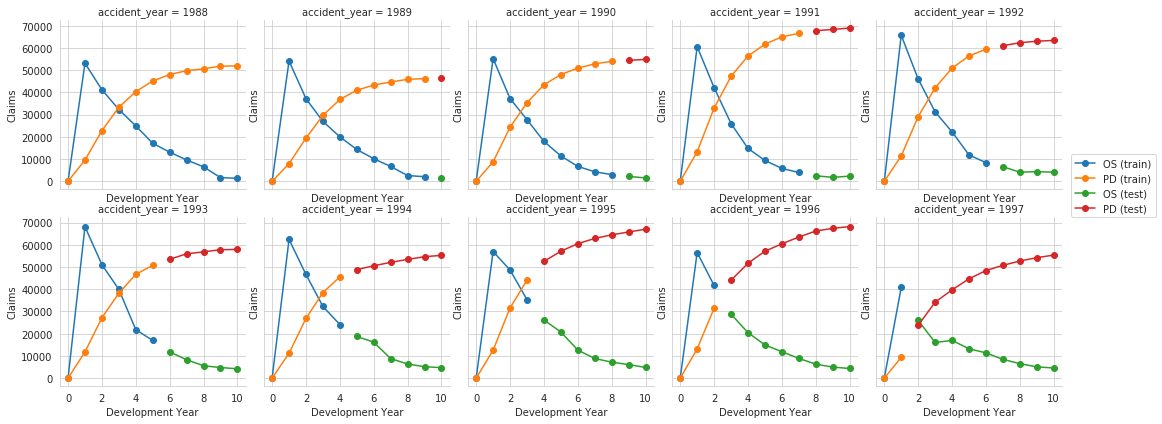

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

test_lossdata=clean_testgraph(337)

#Lattice plotting
#Step 1: Initialize grid
g = sns.set_style("whitegrid")
g = sns.FacetGrid(test_lossdata, col="accident_year", hue="type", col_wrap=5)

#Step 2: Plot using .map
g.map(plt.plot, "dev", "claims", marker='o')
plt.legend(loc=(1.05,1))
g.set(xlabel='Development Year',ylabel='Claims')

Reminder:
$$Ultimate Loss Ratio = \cfrac{Total Paid Loss}{Total Earned Premium}$$

Therefore, actuaries usually use trianges to get the ULR to project future claims (future liabilities of the company) in order to decide how much to reserve. But there's so much to consider when using historical data to determine future claims, e.g. changes in claims department operation, inclusion of technology etc that may change the pattern of settlements or change in claim amounts and so on. Therefore we are exploring a different approach to do reserving.

## Nonlinear Regression
* A regression method is considered linear as long as it is in the linear form as follows:
$$y=\beta_0+\beta_1x_1+\beta_2x_2 ...+\beta_nx_n$$

* Linear regression doesn't just mean fitting a STRAIGHT line that is closest to all data points, linear regression can still model CURVATURES with models such as follows, note that the parameters are still linear:
$$y=\beta_0+\beta_1x_1+\beta_2x_2^2$$

* Hence we can say a regression method is nonlinear when it is nonlinear in parameters.
* Generally, if a regression equation does not follow the rules for a linear model, then it must be a nonlinear model.

So far I've been able to run the code in predicting the parameter estimates by feeding in sample data using R with the help of a blogger's post who also tried reproducing Jake's work but I'm still struggling to plot the predictions in Python or in R itself. I'll probably be able to present it in #004, so whatever that's down there may seem incomplete. 

## Nonlinear least squares
* Believe that the data is generated from a Normal distribution.
* Assumes constant variance across outstanding and paid claims.
* Parameters RLR and RRF are the same across all accident years, i.e. assumes same ULR for all years.

In [ ]:
# Prediction result in R
# Nonlinear regression model
#   model: loss_train ~ my.f(dev, premium, lk_er = lker, lk_p = lkp, lRLR = lRLR,     lRRF = lRRF, delta = delta)
#    data: lossData0[cal <= max(accident_year)]
#    lker    lRLR     lkp    lRRF 
#  0.8621 -0.1090 -0.8646 -0.4397 
#  residual sum-of-squares: 0.3505

# Number of iterations to convergence: 5 
# Achieved convergence tolerance: 2.84e-06
    
## Bringing back the parameters to their original scale, logarithmic was applied to ensure positivity
#       ker       RLR        kp       RRF 
# 2.4375609 0.8985600 0.4231800 0.6466241 

## Nonlinear mixed effect

Using nonlinear mixed effect means we have both parameters with fixed and random effects. Now, we will allow parameters RLR and RRF to change across accident years, which is more realistic than fixing them constant across accident years.
The model also allows variances for OS and PD.

In [ ]:
## Prediction result in R

# > m1
# Nonlinear mixed-effects model fit by maximum likelihood
#   Model: loss_train ~ my.f(dev, premium, lk_er = lker, lk_p = lkp, lRLR = lRLR,      lRRF = lRRF, delta = delta) 
#   Data: lossData0[cal <= max(accident_year)] 
#   Log-likelihood: 270.2174
#   Fixed: lker + lRLR + lkp + lRRF ~ 1 
#       lker       lRLR        lkp       lRRF 
#  0.4102734  0.0225969 -0.7946097 -0.4049579 

# Random effects:
#  Formula: list(lRLR ~ 1, lRRF ~ 1)
#  Level: accident_year
#  Structure: Diagonal
#             lRLR      lRRF  Residual
# StdDev: 0.186949 0.1318405 0.0333756

# > summary(m1)
# Variance function:
#  Structure: Different standard deviations per stratum
#  Formula: ~1 | deltaf 
#  Parameter estimates:
#        os      paid 
# 1.0000000 0.1805809 
# Number of Observations: 110
# Number of Groups: 10 
    
# Nonlinear mixed-effects model fit by maximum likelihood
#   Model: loss_train ~ my.f(dev, premium, lk_er = lker, lk_p = lkp, lRLR = lRLR,      lRRF = lRRF, delta = delta) 
#  Data: lossData0[cal <= max(accident_year)] 
#         AIC       BIC   logLik
#   -524.4347 -502.8309 270.2174

# Random effects:
#  Formula: list(lRLR ~ 1, lRRF ~ 1)
#  Level: accident_year
#  Structure: Diagonal
#             lRLR      lRRF  Residual
# StdDev: 0.186949 0.1318405 0.0333756

# Variance function:
#  Structure: Different standard deviations per stratum
#  Formula: ~1 | deltaf 
#  Parameter estimates:
#        os      paid 
# 1.0000000 0.1805809 
# Fixed effects: lker + lRLR + lkp + lRRF ~ 1 
#           Value  Std.Error DF    t-value p-value
# lker  0.4102734 0.05624431 97   7.294487  0.0000
# lRLR  0.0225969 0.06751438 97   0.334698  0.7386
# lkp  -0.7946097 0.03483363 97 -22.811566  0.0000
# lRRF -0.4049579 0.05558068 97  -7.285948  0.0000
#  Correlation: 
#      lker   lRLR   lkp   
# lRLR -0.375              
# lkp  -0.928  0.388       
# lRRF  0.522 -0.282 -0.572

# Standardized Within-Group Residuals:
#         Min          Q1         Med          Q3         Max 
# -2.63652221 -0.52065559  0.03990076  0.61348838  2.01628712 

# Number of Observations: 110
# Number of Groups: 10 

# > coef(m1)
#           lker        lRLR        lkp       lRRF
# 1988 0.4102734 -0.15859816 -0.7946097 -0.5226660
# 1989 0.4102734 -0.07802509 -0.7946097 -0.5496317
# 1990 0.4102734 -0.03253702 -0.7946097 -0.3964535
# 1991 0.4102734 -0.09396949 -0.7946097 -0.2251189
# 1992 0.4102734 -0.05554195 -0.7946097 -0.4117284
# 1993 0.4102734 -0.10634810 -0.7946097 -0.5759195
# 1994 0.4102734 -0.12218076 -0.7946097 -0.4932472
# 1995 0.4102734  0.20864027 -0.7946097 -0.3233851
# 1996 0.4102734  0.34098629 -0.7946097 -0.2417788
# 1997 0.4102734  0.32354297 -0.7946097 -0.3096503

# Rescaling and calculating ULR for each accident year
#        RLR   RRF   ULR
# 1988 0.853 0.593 0.506
# 1989 0.925 0.577 0.534
# 1990 0.968 0.673 0.651
# 1991 0.910 0.798 0.727
# 1992 0.946 0.663 0.627
# 1993 0.899 0.562 0.505
# 1994 0.885 0.611 0.540
# 1995 1.232 0.724 0.892
# 1996 1.406 0.785 1.104
# 1997 1.382 0.734 1.014

# Variances for OS and PD
# > (sig_delta <- sapply(split(resid(m1), lossData0[cal<=max(accident_year)]$deltaf), sd))
#          os        paid 
# 0.032065010 0.005522209 

# Variances of RLR and RRF between development years
# > VarCorr(m1)
# accident_year = pdDiag(list(lRLR ~ 1,lRRF ~ 1)) 
#          Variance   StdDev   
# lRLR     0.03494992 0.1869490
# lRRF     0.01738192 0.1318405
# Residual 0.00111393 0.0333756

## Rescaling fixed effects
# > m1_fe <- data.table(summary(m1)$tTable)[, exp(Value + 0.5*`Std.Error`^2)]
# > names(m1_fe) <- c("ker", "RLR", "kp", "RRF")
# > m1_fe
#       ker       RLR        kp       RRF 
# 1.5096157 1.0251880 0.4520317 0.6680359 

## Next up
* The challenge with using these nonlinear regression methods is that we have to come up with a starting parameters estimate to begin optimization. Jake's paper mentioned that we can just pick them using judgement (I'm not sure if I should be skeptical since I'm quite a careless person myself), or using a self-starting algorithm, which is provided in the Appendix.
* The nonlinear regression approaches above are still frequentist's methods. After plotting the predictions I'll move into Bayesian methods.

### References
https://magesblog.com/post/hierarchical-compartmental-reserving-models/